# # This file contains a subset of the quick draw classes.

In [2]:
!wget 'https://raw.githubusercontent.com/zaidalyafeai/zaidalyafeai.github.io/master/sketcher/mini_classes.txt'

--2020-03-06 20:44:46--  https://raw.githubusercontent.com/zaidalyafeai/zaidalyafeai.github.io/master/sketcher/mini_classes.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 760 [text/plain]
Saving to: ‘mini_classes.txt’

mini_classes.txt    100%[===================>]     760  --.-KB/s    in 0s      

2020-03-06 20:44:46 (113 MB/s) - ‘mini_classes.txt’ saved [760/760]



# Read the classes names 

In [0]:
f = open("mini_classes.txt","r")
# And for reading use
classes = f.readlines()
f.close()

In [0]:
classes = [c.replace('\n','').replace(' ','_') for c in classes]

# Download the Dataset 

Loop over the classes and download the currospondent data

In [0]:
!mkdir data

In [0]:
import urllib.request
def download():
  
  base = 'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/'
  for c in classes:
    cls_url = c.replace('_', '%20')
    path = base+cls_url+'.npy'
    print(path)
    urllib.request.urlretrieve(path, 'data/'+c+'.npy')

In [7]:
download() 

https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/drums.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/sun.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/laptop.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/anvil.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/baseball%20bat.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/ladder.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/eyeglasses.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/grapes.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/book.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/dumbbell.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/traffic%20light.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/wristwatch.npy
https://storage.googleapis.com/quickdraw_dat

# Imports

In [8]:
import os
import glob
import numpy as np
from tensorflow.keras import layers
from tensorflow import keras 
import tensorflow as tf

import matplotlib.pyplot as plt
from random import randint
%matplotlib inline 

# # Load the Data 

Each class contains different number samples of arrays stored as .npy format. Since we have some memory limitations we only load 5000 images per class.  

In [0]:
def load_data(root, vfold_ratio=0.2, max_items_per_class= 4000 ):
    all_files = glob.glob(os.path.join(root, '*.npy'))

    #initialize variables 
    x = np.empty([0, 784])
    y = np.empty([0])
    class_names = []

    #load each data file 
    for idx, file in enumerate(all_files):
        data = np.load(file)
        data = data[0: max_items_per_class, :]
        labels = np.full(data.shape[0], idx)

        x = np.concatenate((x, data), axis=0)
        y = np.append(y, labels)

        class_name, ext = os.path.splitext(os.path.basename(file))
        class_names.append(class_name)

    data = None
    labels = None
    
    #randomize the dataset 
    permutation = np.random.permutation(y.shape[0])
    x = x[permutation, :]
    y = y[permutation]

    #separate into training and testing 
    vfold_size = int(x.shape[0]/100*(vfold_ratio*100))

    x_test = x[0:vfold_size, :]
    y_test = y[0:vfold_size]

    x_train = x[vfold_size:x.shape[0], :]
    y_train = y[vfold_size:y.shape[0]]
    return x_train, y_train, x_test, y_test, class_names

In [0]:
x_train, y_train, x_test, y_test, class_names = load_data('data')
num_classes = len(class_names)
image_size = 28

In [11]:
print(len(x_train))

320000


Some random data

ladder


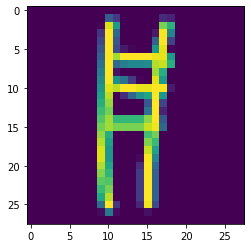

In [12]:
idx = randint(0, len(x_train))
plt.imshow(x_train[idx].reshape(28,28)) 
print(class_names[int(y_train[idx].item())])

# Preprocess the Data

In [0]:
# Reshape and normalize
x_train = x_train.reshape(x_train.shape[0], image_size, image_size, 1).astype('float32')
x_test = x_test.reshape(x_test.shape[0], image_size, image_size, 1).astype('float32')

x_train /= 255.0
x_test /= 255.0

# Convert class vectors to class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# The Model

In [0]:
# Define model

def model():
  model = keras.Sequential()
  model.add(layers.Convolution2D(16, (3, 3),
                          padding='same',
                          input_shape=x_train.shape[1:], activation='relu'))
  model.add(layers.MaxPooling2D(pool_size=(2, 2)))
  model.add(layers.Convolution2D(32, (3, 3), padding='same', activation= 'relu'))
  model.add(layers.MaxPooling2D(pool_size=(2, 2)))
  model.add(layers.Convolution2D(64, (3, 3), padding='same', activation= 'relu'))
  model.add(layers.MaxPooling2D(pool_size =(2,2)))
  model.add(layers.Flatten())
  model.add(layers.Dense(128, activation='relu'))
  model.add(layers.Dense(100, activation='softmax')) 
  # Train model
  adam = tf.train.AdamOptimizer()
  model.compile(loss='categorical_crossentropy',
                optimizer=adam,
                metrics=['top_k_categorical_accuracy'])
  print(model.summary())

  return model

In [17]:
model = model()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 3, 3, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 576)              

# Training

In [21]:
history = model.fit(x = x_train, y = y_train, validation_split=0.1, batch_size = 256, verbose=1, epochs=30)

Train on 288000 samples, validate on 32000 samples
Epoch 1/30
288000/288000 [==============================] - 211s 732us/sample - loss: 1.3345 - top_k_categorical_accuracy: 0.8823 - val_loss: 1.2235 - val_top_k_categorical_accuracy: 0.8947
Epoch 2/30
288000/288000 [==============================] - 212s 735us/sample - loss: 1.1184 - top_k_categorical_accuracy: 0.9074 - val_loss: 1.1096 - val_top_k_categorical_accuracy: 0.9088
Epoch 3/30
288000/288000 [==============================] - 211s 733us/sample - loss: 1.0139 - top_k_categorical_accuracy: 0.9176 - val_loss: 1.0243 - val_top_k_categorical_accuracy: 0.9155
Epoch 4/30
288000/288000 [==============================] - 211s 731us/sample - loss: 0.9463 - top_k_categorical_accuracy: 0.9245 - val_loss: 1.0056 - val_top_k_categorical_accuracy: 0.9171
Epoch 5/30
288000/288000 [==============================] - 211s 732us/sample - loss: 0.8972 - top_k_categorical_accuracy: 0.9293 - val_loss: 0.9542 - val_top_k_categorical_accuracy: 0.9228

# Plotting Learning Curve

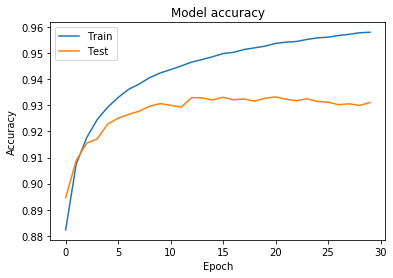

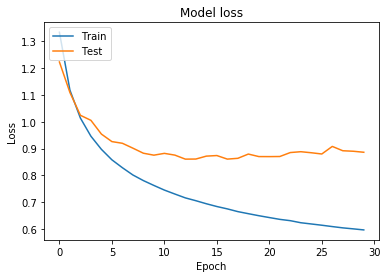

In [26]:
# Plot training & validation accuracy values
plt.plot(history.history['top_k_categorical_accuracy'])
plt.plot(history.history['val_top_k_categorical_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Testing

In [27]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test accuarcy: {:0.2f}%'.format(score[1] * 100))

Test accuarcy: 93.08%


# Prototyping with CNN

As per the accuracy results, we have decided to go with CNN

Feeding data to CNN model

In [0]:
def predictDrawing(img):
  plt.imshow(img.squeeze()) 
  pred = model.predict(np.expand_dims(img, axis=0))[0]
  ind = (-pred).argsort()[:5]
  latex = [class_names[x] for x in ind]
  print(latex)

['car', 'frying_pan', 'headphones', 'helmet', 'bird']


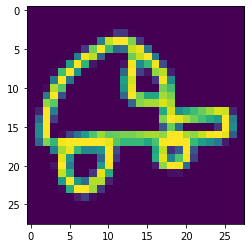

In [29]:
idx = randint(0, len(x_test))
img = x_test[idx]
predictDrawing(img)

['wristwatch', 'frying_pan', 'eyeglasses', 'bird', 'knife']


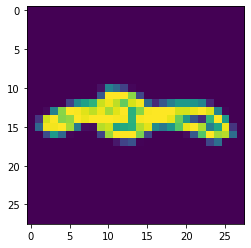

In [30]:
idx = randint(2, len(x_test))
img = x_test[idx]
predictDrawing(img)

['cup', 'coffee_cup', 'drums', 'bread', 'helmet']


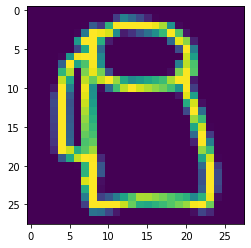

In [31]:
idx = randint(5, len(x_test))
img = x_test[idx]
predictDrawing(img)